# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
import pandas as pd
df = pd.read_csv('texts.csv')
df.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [2]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';', decimal=b',')
pr_all.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,133.43,132.60,133.90,132.00,16037970
1,07.12.2017,133.70,133.02,133.87,132.81,18198430
2,06.12.2017,133.33,134.00,134.29,132.91,14641730
3,05.12.2017,133.48,133.65,133.99,132.78,12684800
4,04.12.2017,133.01,133.77,134.00,131.93,17818980


In [3]:
pr_all.dropna(inplace=True)
pr_all.rename( columns={"Date": "date"}, inplace= True)
pr_all.date = pd.to_datetime(pr_all.date, dayfirst=True, errors='coerce')

    
#pr_all.Open.astype(int)
#pr_all.ClosingPrice.astype(int)
#pr_all.DailyHigh.astype(int)
#pr_all.DailyLow.astype(int)    
     


In [4]:
df.date = pd.to_datetime(df.date, dayfirst=True, errors='coerce')
df.dropna(inplace=True)
df.head()

,date,text
0,2017-11-09,Компания рассчитывает на решение по газовому с...
1,2017-11-08,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,2017-11-01,Новая редакция американских санкций ставит по...
3,2017-10-30,"Как стало известно “Ъ”, известный на рынке ри..."
4,2017-10-23,"НОВАТЭК, который через пять лет собирается за..."


### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

In [5]:
# Токинезация  и приведение к нижнему регистру
import re
regex = re.compile("[А-Яа-я----]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

In [6]:
# удаление стоп слов
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-', '-']

print(mystopwords)
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
df.text = df.text.apply(remove_stopwords)   

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [7]:
%%time
# Лематизация
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 1.13 s, sys: 100 ms, total: 1.23 s
Wall time: 7.61 s


In [8]:
# Удаление стоп-лемм
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [9]:
all_data = pr_all.merge(df, on='date', how='left', sort=False)
all_data = all_data.fillna('none')
print(all_data.info())
all_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 7 columns):
date            1964 non-null datetime64[ns]
Open            1964 non-null float64
ClosingPrice    1964 non-null float64
DailyHigh       1964 non-null float64
DailyLow        1964 non-null float64
VolumePcs       1964 non-null int64
text            1964 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 122.8+ KB
None


,date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,text
0,2017-12-08,133.43,132.60,133.90,132.00,16037970,none
1,2017-12-07,133.70,133.02,133.87,132.81,18198430,none
2,2017-12-06,133.33,134.00,134.29,132.91,14641730,none
3,2017-12-05,133.48,133.65,133.99,132.78,12684800,none
4,2017-12-04,133.01,133.77,134.00,131.93,17818980,none


### Корреляция между средней длинной текста за день и ценой закрытия

In [10]:
from scipy.stats import spearmanr
import seaborn as sns


In [11]:
len_corr_price = pd.DataFrame({'length' : all_data.text.apply(len), 'price': all_data.ClosingPrice}) 


In [12]:
len_corr_price.describe()

,length,price
count,1964.000000,1964.000000
mean,359.132892,151.561726
std,447.898899,24.029908
min,4.000000,107.170000
25%,4.000000,135.637500
50%,259.000000,145.700000
75%,546.250000,162.865000
max,3186.000000,244.000000


In [13]:
# будем отображать графики прямо в jupyter'e
%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8,5

Populating the interactive namespace from numpy and matplotlib


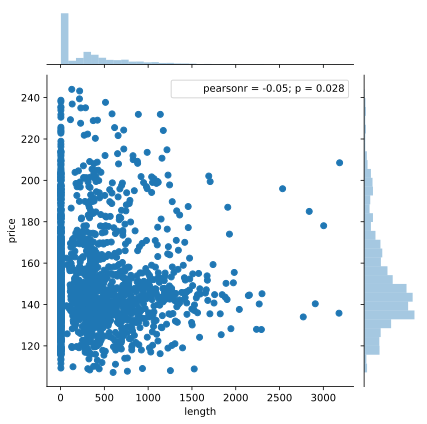

In [14]:
sns.jointplot(x='length', y='price', 
              data=len_corr_price, kind='scatter');

### Корреляция между количеством упоминаний Алексея Миллера и ценой закрытия.

In [15]:
import re

In [16]:
mill_corr_price = pd.DataFrame({'count' : all_data.text, 'price': all_data.ClosingPrice}) 

In [17]:
mill_corr_price.head()

,count,price
0,none,132.60
1,none,133.02
2,none,134.00
3,none,133.65
4,none,133.77


In [18]:
prog = re.compile('миллер*')
l = []
for i, row in mill_corr_price.iterrows():
    l.append(len(prog.findall(row['count'])))
   
l
mill_corr_price['count'] = l

In [19]:
mill_corr_price.describe()

,count,price
count,1964.000000,1964.000000
mean,0.073320,151.561726
std,0.381328,24.029908
min,0.000000,107.170000
25%,0.000000,135.637500
50%,0.000000,145.700000
75%,0.000000,162.865000
max,6.000000,244.000000


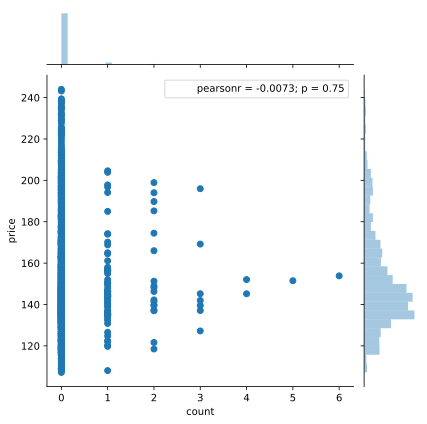

In [20]:
sns.jointplot(x='count', y='price', 
              data=mill_corr_price, kind='scatter');

### Упоминаний какого газопровода в статьях больше: 
"северный поток "турецкий поток"?

In [21]:
prog = re.compile('северный поток')
l = []
for i, row in all_data.iterrows():
    l.append(len(prog.findall(row['text'])))
sum (l)


15

In [22]:
prog = re.compile('турецкий поток')
l = []
for i, row in all_data.iterrows():
    l.append(len(prog.findall(row['text'])))
sum (l)

39

### Находим все прилагательные, стоящие после слова "санкции"

In [23]:
df1 = pd.read_csv('texts.csv')
df1.head()
#all_data.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [24]:
s = ''
for i, row in df1.iterrows():
    s = s + row.text

In [25]:
import re, sys
 
def safeSplit(regex, text):
    res=[]
    sear=regex.search(text)
    while sear:
        res.append(text[:sear.end()])
        text=text[sear.end():]
        sear=regex.search(text)
    res.append(text)
    return res
 

re1 = re.compile("""
    (?:
        (?:
            (?<!\\d(?:р|г|к))
            (?<!и\\.т\\.(?:д|п))
            (?<!и(?=\\.т\\.(?:д|п)\\.))
            (?<!и\\.т(?=\\.(?:д|п)\\.))
            (?<!руб|коп)
        \\.) |
        [!?\\n]
    )+
    """, re.X)
 
s =  "\n".join(safeSplit(re1, s))

In [26]:
f = open('text.txt', 'w')
f.write(s)

921778

In [45]:
! cat text.txt | docker run --rm -i inemo/syntaxnet_rus > data.conll

2018-01-06 21:34:01.059171: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-06 21:34:01.059231: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-06 21:34:01.059258: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2018-01-06 21:34:01.060848: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-06 

2018-01-06 21:34:02.054247: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2018-01-06 21:34:02.087816: I syntaxnet/term_frequency_map.cc:101] Loaded 31 terms from ./syntaxnet/models/Russian-SynTagRus/tag-map.
2018-01-06 21:34:02.120075: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2018-01-06 21:34:07.670393: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Building training network with parameters: feature_sizes: [12 20 20 20] domain_sizes: [    37     66     33 103475]
2018-01-06 21:34:08.393995: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
2018-01-06 21:34:08.469130: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Building trai

2018-01-06 21:34:14.391398: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2018-01-06 21:34:14.427485: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2018-01-06 21:34:17.549744: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
2018-01-06 21:34:19.974304: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
2018-01-06 21:34:20.155952: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Processed 1024 documents
INFO:tensorflow:Processed 1024 documents
INFO:tensorflow:Processed 1024 documents
INFO:tensorflow:Processed 1024 documents
INFO:tensorflow:Processed 1024 documents
INFO:tensorflow:Processed 1024 documents
INFO:tensorflow:Processed 1024 documents
INFO:ten

In [46]:
from nltk import DependencyGraph
import codecs

processed_sentences = []
sentence = []
for line in codecs.open('data.conll', 'r'):
    if len(line) == 1:
        processed_sentences.append(sentence)
        sentence = []
    else:
        word = line.split("\t")
        sentence.append(word)

deps = []
for sentence in processed_sentences:
    s = u""
    for line in sentence:
        s += u"\t".join(line) + u'\n'
    deps.append(s)

for sent_dep in deps:
    graph = DependencyGraph(tree_str=sent_dep, cell_separator='\t')
    for triple in graph.triples():
        if triple[1] == 'amod' and triple[0][0] == 'санкции':
            print(triple[0][0], triple[2][0])
        if triple[1] == 'amod' and triple[0][0] == 'санкций':
            print(triple[0][0], triple[2][0])
#    tree = graph.tree()
#    print(tree.pretty_print())

санкций американских
санкций введенных
санкций западных
санкции западные
санкции персональные
санкции штрафные
санкций западных
санкций западных
санкций секторальных
санкций секторальных
санкций западных
санкций штрафных
санкций штрафных


## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [29]:
all_data_bin = pr_all.merge(df, on='date', how='left', sort=False)

all_data_bin.head()

,date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,text
0,2017-12-08,133.43,132.60,133.90,132.00,16037970,NaN
1,2017-12-07,133.70,133.02,133.87,132.81,18198430,NaN
2,2017-12-06,133.33,134.00,134.29,132.91,14641730,NaN
3,2017-12-05,133.48,133.65,133.99,132.78,12684800,NaN
4,2017-12-04,133.01,133.77,134.00,131.93,17818980,NaN


In [30]:
all_data_bin['ClosingPrice_bin'] = 0
all_data_bin.head()

,date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,text,ClosingPrice_bin
0,2017-12-08,133.43,132.60,133.90,132.00,16037970,NaN,0
1,2017-12-07,133.70,133.02,133.87,132.81,18198430,NaN,0
2,2017-12-06,133.33,134.00,134.29,132.91,14641730,NaN,0
3,2017-12-05,133.48,133.65,133.99,132.78,12684800,NaN,0
4,2017-12-04,133.01,133.77,134.00,131.93,17818980,NaN,0


In [31]:
for i, row in all_data_bin.iterrows():
    if i+1 < len(all_data_bin):
        if all_data_bin.ClosingPrice.iloc[i] >= all_data_bin.ClosingPrice.iloc[i+1]:
            all_data_bin['ClosingPrice_bin'].iloc[i] = 1
        
all_data_bin.head(10)

/home/vladimir/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,text,ClosingPrice_bin
0,2017-12-08,133.43,132.60,133.90,132.00,16037970,NaN,0
1,2017-12-07,133.70,133.02,133.87,132.81,18198430,NaN,0
2,2017-12-06,133.33,134.00,134.29,132.91,14641730,NaN,1
3,2017-12-05,133.48,133.65,133.99,132.78,12684800,NaN,0
4,2017-12-04,133.01,133.77,134.00,131.93,17818980,NaN,1
5,2017-12-01,132.49,133.02,133.32,131.72,24755830,NaN,1
6,2017-11-30,133.00,132.15,134.31,132.00,40024830,NaN,0
7,2017-11-29,134.85,133.55,134.86,132.97,27263040,NaN,0
8,2017-11-28,133.23,135.18,135.18,132.55,26663710,NaN,1
9,2017-11-27,133.69,133.50,135.19,132.80,27713150,NaN,0


In [32]:
#all_data_bin = all_data_bin.fillna('')
all_data_bin = all_data_bin.dropna(axis=0)

In [33]:
DROP_COL = ['Open', 'ClosingPrice', 'DailyHigh', 'DailyLow', 'VolumePcs']
all_data_bin = all_data_bin.drop(DROP_COL, axis=1)

In [34]:
#train = all_data_bin.iloc[481:]
train = all_data_bin.iloc[253:]

In [35]:
#test = all_data_bin.iloc[:481]
test = all_data_bin.iloc[:253]

In [36]:
train.head()

,date,text,ClosingPrice_bin
482,2015-12-29,газпром отменять проведение рекордный история ...,1
484,2015-12-25,газпром прогнозировать увеличение чистый прибы...,0
485,2015-12-24,правительство приостанавливать обсуждение вопр...,1
486,2015-12-23,фас продолжать атака газпром соглашаться повыш...,1
487,2015-12-22,состоятельный банковский -клиент россия начина...,1


In [37]:
test.head(5)

,date,text,ClosingPrice_bin
21,2017-11-09,компания рассчитывать решение газовый спор укр...,0
22,2017-11-08,предполагать ъ газпром воспользоваться жалоба ...,1
26,2017-11-01,новый редакция американский санкция ставить уг...,1
28,2017-10-30,становиться известно ъ известный рынок риск-ме...,1
33,2017-10-23,новатэк пять год собираться запускать камчатка...,1


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(1228)
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
%matplotlib inline

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation


In [116]:
Val1=1
Val2=2

In [144]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(Val1,Val2),
                             max_df=0.95, 
                             min_df=1, 
                             analyzer='char_wb')),
     ('tfidf', TfidfTransformer()),
   ('reducer', TruncatedSVD(n_components=3)),
    ('clf', RandomForestClassifier(n_estimators=500,min_samples_leaf=2, random_state=100))
#     ('clf', MultinomialNB(alpha=1))
])


clf.fit(train.text, train.ClosingPrice_bin)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        s...imators=500, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False))])

In [145]:
predictions = clf.predict(test.text)

Precision:   0.56
Recall:   0.60
F1-measure:   0.58
Accuracy:   0.60
             precision    recall  f1-score   support

          0       0.64      0.60      0.62       138
          1       0.56      0.60      0.58       115

avg / total       0.60      0.60      0.60       253



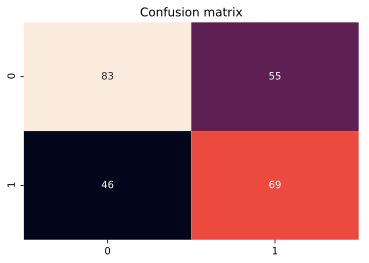

In [146]:
print("Precision: {0:6.2f}".format(precision_score(test.ClosingPrice_bin, predictions)))
print("Recall: {0:6.2f}".format(recall_score(test.ClosingPrice_bin, predictions)))
print("F1-measure: {0:6.2f}".format(f1_score(test.ClosingPrice_bin, predictions)))
print("Accuracy: {0:6.2f}".format(accuracy_score(test.ClosingPrice_bin, predictions)))
print(classification_report(test.ClosingPrice_bin, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(test.ClosingPrice_bin, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     